In [ ]:
!pip install monai
!pip install torchinfo

In [2]:
# import libraries
import os
import torch
import torch.nn as nn
import monai
import numpy as np
import torchvision
import matplotlib
import matplotlib.pyplot as plt
###
from monai.data import Dataset as TorchDataset
from monai.data import DataLoader
from monai.transforms import Compose, LoadImage, ToTensor
from monai.networks.nets import VQVAE
###
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchinfo import summary
###
from sklearn.manifold import TSNE
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
###
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Monai version: {monai.__version__}")


PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
Numpy version: 2.0.2
Monai version: 1.5.1


In [3]:
# Define a method to Scale the intensity of the input data between minv and maxv
class ScaleIntensity:
    def __init__(self, minv=0.0, maxv=1.0):
        self.minv = minv
        self.maxv = maxv

    def __call__(self, img):
        img_min, img_max = img.min(), img.max()
        img = (img - img_min) / (img_max - img_min)  # Normaliser entre 0 et 1
        img = img * (self.maxv - self.minv) + self.minv  # Rescaler entre minv et maxv
        return img

In [4]:
# how many samples per batch to load
batch_size = 64

# define intensity range for each input data to perform image normalization
minv = 0
maxv = 1

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(padding=2),
    ScaleIntensity(minv=minv, maxv=maxv)
])

# Path to store MedNIST dataset
data_dir = "data/MNIST"

# Checks if data has already been downloaded
download = not os.path.exists(data_dir)

# choose the training and test datasets
train_dataset = datasets.MNIST(root='data', train=True, download=download, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=download, transform=transform)

# Split the train_data into a train (80%) and valid (20%) subdataset
train_size = int(0.8 * len(train_dataset))      # 80% for training
valid_size = len(train_dataset) - train_size    # 20% for validation
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# Convert data to Dataset MONAI
train_dataset = TorchDataset(data=[{"image": img, "label": label} for img, label in train_data], transform=Compose([ToTensor()]))
valid_dataset = TorchDataset(data=[{"image": img, "label": label} for img, label in valid_data], transform=Compose([ToTensor()]))
test_dataset = TorchDataset(data=[{"image": img, "label": label} for img, label in test_data], transform=Compose([ToTensor()]))

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.36MB/s]


Training dataset size: 48000
Validation dataset size: 12000
Test dataset size: 12000


The image batch size is (64, 1, 32, 32)


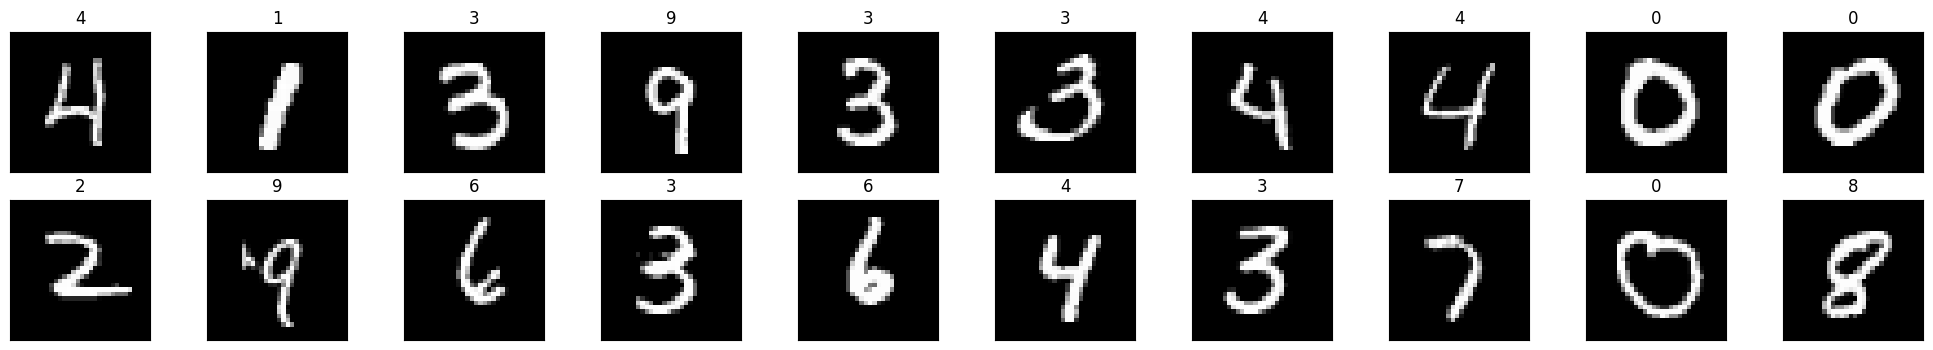

In [5]:
# obtain one batch of training images
dataiter_train = iter(train_loader)
batch = next(dataiter_train)
images, labels = batch["image"], batch["label"]
images = images.numpy()
print(f"The image batch size is {images.shape}")

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

The size of an image from the dataset is (32, 32)


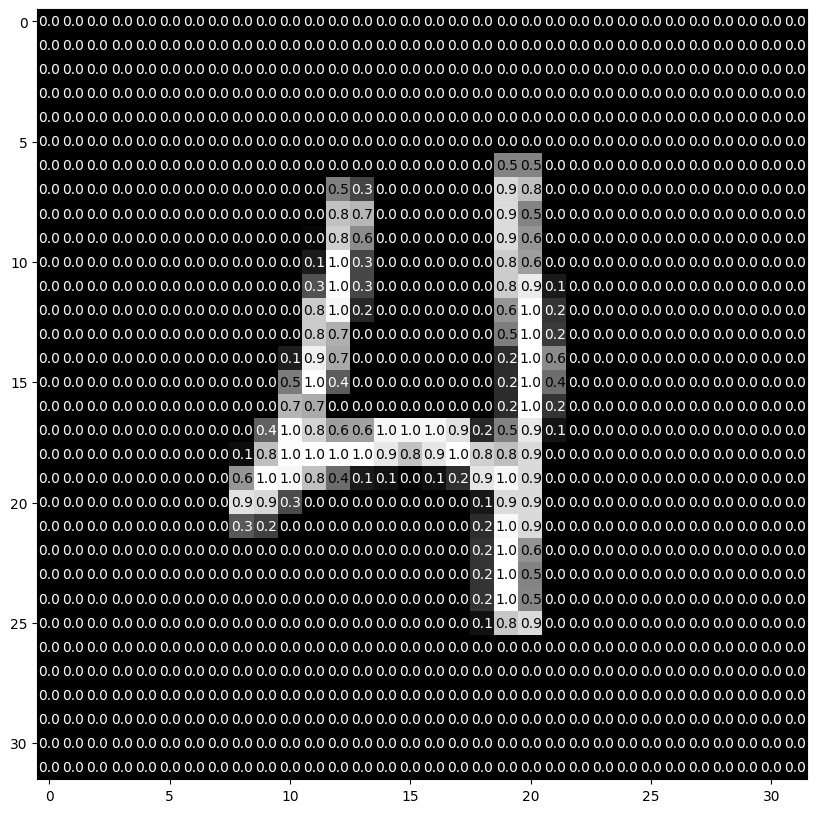

In [6]:
img = np.squeeze(images[0])
print(f"The size of an image from the dataset is {img.shape}")

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [7]:
# Parameters
spatial_dims = 2
in_shape = (1, 32, 32)
in_channels = 1
out_channels = 1
latent_size = 2
channels = (16, 32)
num_res_channels = 256
num_res_layers = 2
downsample_parameters = ((2, 4, 1, 1), (2, 4, 1, 1))
upsample_parameters = ((2, 4, 1, 1, 0), (2, 4, 1, 1, 0))
num_embeddings = 256
embedding_dim = 4


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQVAE(
    spatial_dims=spatial_dims,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    num_res_channels=num_res_channels,
    num_res_layers=num_res_layers,
    downsample_parameters=downsample_parameters,
    upsample_parameters=upsample_parameters,
    num_embeddings=num_embeddings,
    embedding_dim=embedding_dim,
).to(device)

In [9]:
# Print the summary of the encoder network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "num_params"], depth=3, verbose=0
)
summary(model, (1, 1, 32, 32), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
VQVAE                                         [1, 1, 32, 32]            [1, 1, 32, 32]            --
├─Encoder: 1-1                                [1, 1, 32, 32]            [1, 4, 8, 8]              --
│    └─ModuleList: 2-1                        --                        --                        --
│    │    └─Convolution: 3-1                  [1, 1, 32, 32]            [1, 16, 16, 16]           272
│    │    └─VQVAEResidualUnit: 3-2            [1, 16, 16, 16]           [1, 16, 16, 16]           74,000
│    │    └─VQVAEResidualUnit: 3-3            [1, 16, 16, 16]           [1, 16, 16, 16]           74,000
│    │    └─Convolution: 3-4                  [1, 16, 16, 16]           [1, 32, 8, 8]             8,224
│    │    └─VQVAEResidualUnit: 3-5            [1, 32, 8, 8]             [1, 32, 8, 8]             147,744
│    │    └─VQVAEResidualUnit: 3-6            [1, 32, 8, 8]          

In [10]:
## Specify loss and optimization functions
learning_rate = 0.0001
l1_loss = nn.L1Loss()

# Specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Number of epochs to train the model
n_epochs = 20

# Move the model to the device
model = model.to(device)

# Lists to store loss and accuracy for each epoch
train_loss_list = []
valid_metric_list = []
recon_metric_list = []
quant_metric_list = []

best_valid_metric = float('inf')  # to track the best validation loss
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    model.train()  # ensure the model is in training mode
    epoch_loss = 0
    recon_val = 0
    quant_val = 0

    ###################
    # train the model #
    ###################
    for batch_data in train_loader:
        # Load data and target samples stored the current batch_data
        inputs = batch_data["image"].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, quantization_loss = model(images=inputs)
        # calculate the loss
        recon_loss = l1_loss(reconstruction.float(), inputs.float())
        loss = recon_loss + quantization_loss
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        epoch_loss += loss.item() * inputs.size(0)
        recon_val += recon_loss.item() * inputs.size(0)
        quant_val += quantization_loss.item() * inputs.size(0)


    # Calculate average training loss and accuracy over the epoch
    train_loss_list.append(epoch_loss / len(train_loader.dataset))
    recon_metric_list.append(recon_val / len(train_loader.dataset))
    quant_metric_list.append(quant_val / len(train_loader.dataset))

    ###################
    # Validation step #
    ###################
    model.eval()  # set model to evaluation mode
    valid_metric = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            inputs = batch_data["image"].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            reconstruction, quantization_loss = model(images=inputs)
            # calculate the loss
            recon_loss = l1_loss(reconstruction.float(), inputs.float())
            valid_metric += recon_loss.item() * inputs.size(0)

    # Compute average validation loss and accuracy
    valid_metric_list.append(valid_metric / len(valid_loader.dataset))

    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss_list[-1]:.6f} \tValidation metric: {valid_metric_list[-1]:.6f}')

    # Save the model if it has the best validation loss
    if valid_metric_list[-1] < best_valid_metric:
        best_valid_metric = valid_metric_list[-1]
        best_model = model.state_dict()
        best_epoch = epoch + 1  # Save the epoch number


# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_model.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation metric: {best_valid_metric:.6f}")



Epoch: 1 	Training Loss: 0.076113 	Validation metric: 0.028141
Epoch: 2 	Training Loss: 0.023109 	Validation metric: 0.019331
Epoch: 3 	Training Loss: 0.018349 	Validation metric: 0.016731
Epoch: 4 	Training Loss: 0.016377 	Validation metric: 0.015099
Epoch: 5 	Training Loss: 0.015119 	Validation metric: 0.014110
Epoch: 6 	Training Loss: 0.014295 	Validation metric: 0.013432
Epoch: 7 	Training Loss: 0.013628 	Validation metric: 0.012752
Epoch: 8 	Training Loss: 0.013137 	Validation metric: 0.012205
Epoch: 9 	Training Loss: 0.012692 	Validation metric: 0.012004
Epoch: 10 	Training Loss: 0.012307 	Validation metric: 0.011528
Epoch: 11 	Training Loss: 0.011995 	Validation metric: 0.013322
Epoch: 12 	Training Loss: 0.011668 	Validation metric: 0.011038
Epoch: 13 	Training Loss: 0.011451 	Validation metric: 0.010773
Epoch: 14 	Training Loss: 0.011185 	Validation metric: 0.011199
Epoch: 15 	Training Loss: 0.010991 	Validation metric: 0.010552
Epoch: 16 	Training Loss: 0.010822 	Validation me

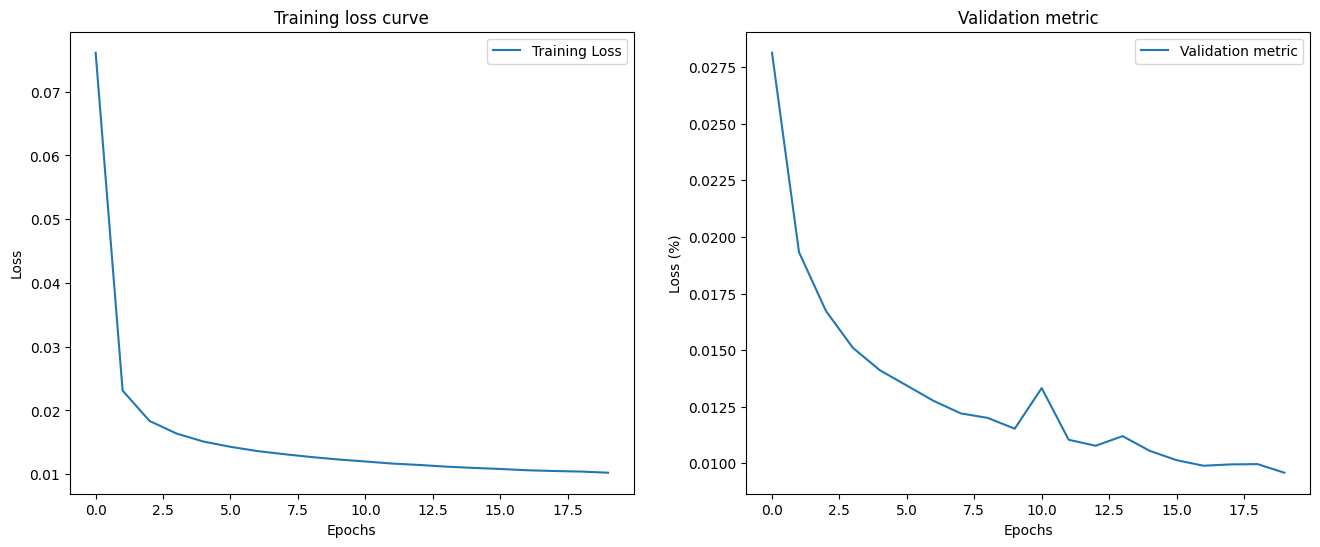

In [12]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation metric
plt.subplot(1, 2, 2)
plt.plot(valid_metric_list, label='Validation metric')
plt.title('Validation metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

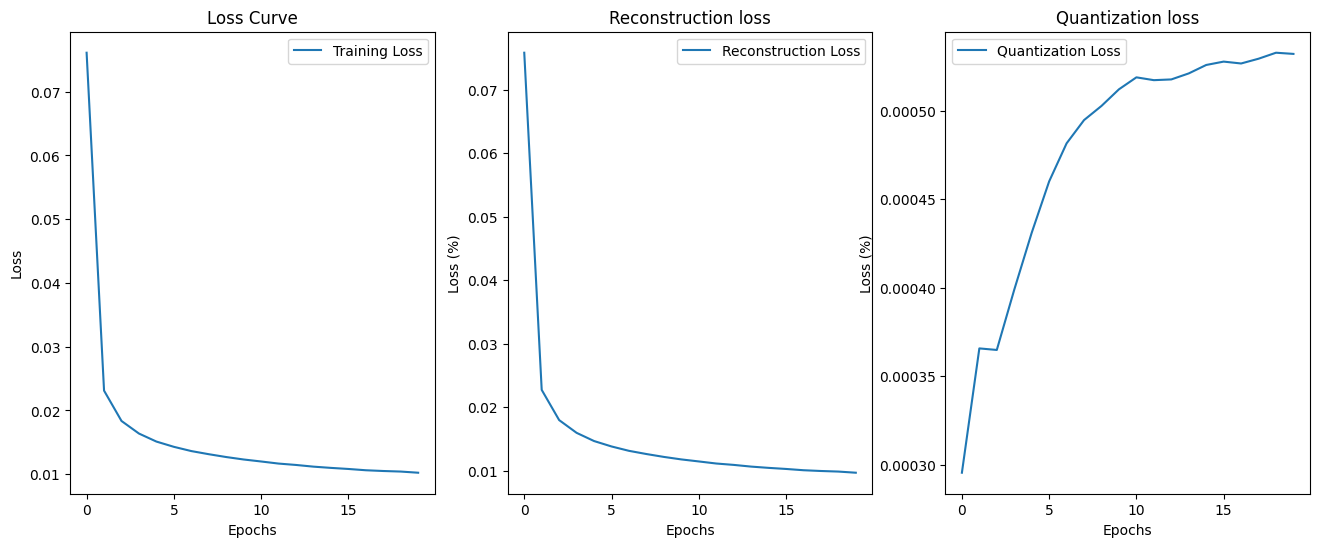

In [13]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 3, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Reconstruction loss
plt.subplot(1, 3, 2)
plt.plot(recon_metric_list, label='Reconstruction Loss')
plt.title('Reconstruction loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

# Plotting Qauntization loss
plt.subplot(1, 3, 3)
plt.plot(quant_metric_list, label='Quantization Loss')
plt.title('Quantization loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

In [14]:
# initialize lists to monitor test loss and accuracy
test_metric = 0.0

model.eval() # prep model for *evaluation*

with torch.no_grad():  # Deactivate the gradient computations
    for batch_data in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        inputs = batch_data["image"].to(device)
        reconstruction, quantization_loss = model(images=inputs)
        # calculate the loss
        recon_loss = l1_loss(reconstruction.float(), inputs.float())
        test_metric += recon_loss.item() * inputs.size(0)

# calculate and print avg test loss
test_metric = test_metric / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_metric))

# Prepare next cell
dataiter = iter(test_loader)

Test Loss: 0.009582



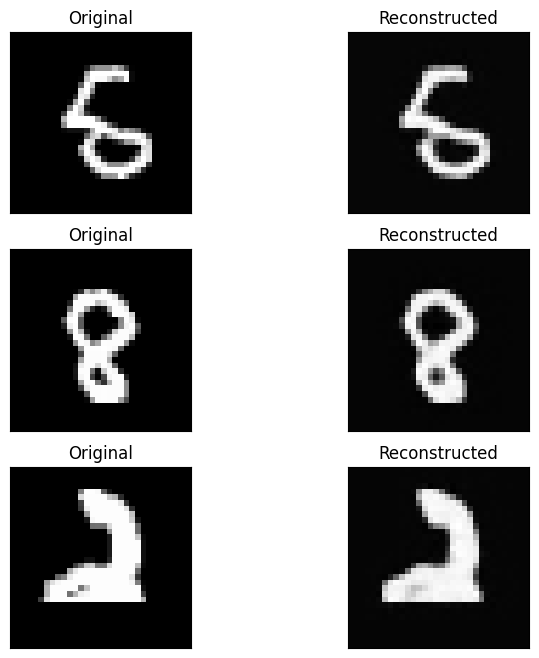

In [15]:
# obtain one batch of test images
batch_data = next(dataiter)

# get sample outputs
inputs = batch_data["image"].to(device)
recons, _ = model(images=inputs)
# reconstruction images for display
recons = recons.detach().cpu().numpy()
inputs = inputs.detach().cpu().numpy()

# Plot the image, label and prediction
fig = plt.figure(figsize=(8, 8))
for idx in range(3):
    ax = fig.add_subplot(3, 2, 2*idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(inputs[idx]), cmap='gray')
    ax.set_title('Original')
    ax = fig.add_subplot(3, 2, 2*idx+2, xticks=[], yticks=[])
    ax.imshow(np.squeeze(recons[idx]), cmap='gray')
    ax.set_title('Reconstructed')

Embedding size (256, 4)


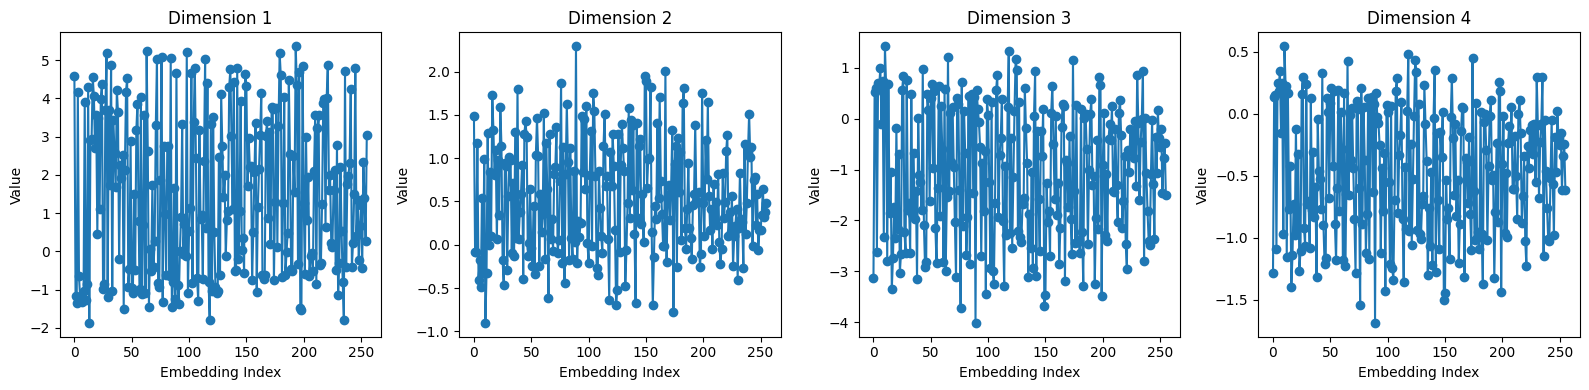

In [16]:
embeddings = model.state_dict()["quantizer.quantizer.embedding.weight"]
embeddings_np = embeddings.detach().cpu().numpy()
print(f"Embedding size {embeddings_np.shape}")

# Display the values for each of the 4th dimensions for each 256 embedding vectors
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].plot(embeddings_np[:, i], marker='o')
    axes[i].set_title(f"Dimension {i+1}")
    axes[i].set_xlabel("Embedding Index")
    axes[i].set_ylabel("Value")
plt.tight_layout()
plt.show()

In [17]:
downsampling_ratio = 5
counter = 0  # counter initialisation

model.eval() # prep model for *evaluation*
encoder_accumulated = []
quantization_accumulated = []
labels_accumulated = []

with torch.no_grad():  # Deactivate the gradient computations
    for batch_data in test_loader:
        counter += 1
        if counter % downsampling_ratio == 0:
            # forward pass: compute predicted outputs by passing inputs to the model
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            z = model.encode(inputs)
            q, _ = model.quantize(z)
            encoder_accumulated.append(z.cpu().numpy())
            quantization_accumulated.append(q.cpu().numpy())
            labels_accumulated.append(labels.cpu().numpy())

encoder_accumulated = np.concatenate(encoder_accumulated, axis=0)
quantization_accumulated = np.concatenate(quantization_accumulated, axis=0)
labels_accumulated = np.concatenate(labels_accumulated, axis=0)
encoder_flattened = encoder_accumulated.reshape(encoder_accumulated.shape[0], -1)
quantization_flattened = quantization_accumulated.reshape(quantization_accumulated.shape[0], -1)
print(f"Size of the latent matrix passed to the t-SNE method (Nb Sample, vector dimensionality) = {encoder_flattened.shape}")

# Apply t-SNE to reduce the dimensionality to 2 and allows a visualization of the latent space
tsne1 = TSNE(n_components=2, random_state=42)
encoder_tsne = tsne1.fit_transform(encoder_flattened)
tsne2 = TSNE(n_components=2, random_state=42)
quantization_tsne = tsne2.fit_transform(quantization_flattened)


Size of the latent matrix passed to the t-SNE method (Nb Sample, vector dimensionality) = (2368, 256)


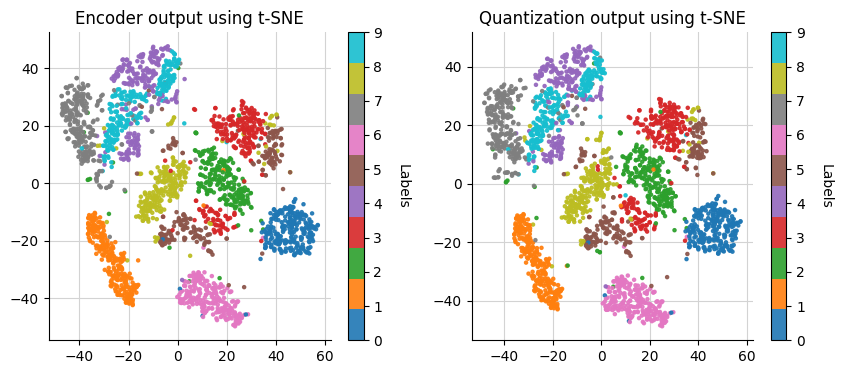

In [18]:
show_grid = True

fig = plt.figure(figsize=(10, 14) if not show_grid else (10, 4))

# create a scatter plot of the embeddings, colored by the labels
ax = fig.add_subplot(1, 2, 1)
scatter = ax.scatter(
    x=encoder_tsne[:, 0],
    y=encoder_tsne[:, 1],
    c=labels_accumulated,
    cmap="tab10",
    s=5,
    alpha=0.9,
    zorder=2,
    )

# remove the top and right spines from the plot
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Encoder output using t-SNE")
# add a colorbar to the plot
cbar = plt.colorbar(scatter, ax=ax)
cbar.ax.set_ylabel("Labels", rotation=270, labelpad=20)
# if show is True, display the plot
if show_grid:
    # add a grid to the plot
    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
    # plt.show()
# otherwise, save the plot to a file and close the figure
else:
    plt.savefig("latent_space.png", bbox_inches="tight")
    plt.close()


# create a scatter plot of the embeddings, colored by the labels
ax = fig.add_subplot(1, 2, 2)
scatter = ax.scatter(
    x=quantization_tsne[:, 0],
    y=quantization_tsne[:, 1],
    c=labels_accumulated,
    cmap="tab10",
    s=5,
    alpha=0.9,
    zorder=2,
    )

# remove the top and right spines from the plot
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Quantization output using t-SNE")
# add a colorbar to the plot
cbar = plt.colorbar(scatter, ax=ax)
cbar.ax.set_ylabel("Labels", rotation=270, labelpad=20)
# if show is True, display the plot
if show_grid:
    # add a grid to the plot
    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
    # plt.show()
# otherwise, save the plot to a file and close the figure
else:
    plt.savefig("latent_space.png", bbox_inches="tight")
    plt.close()

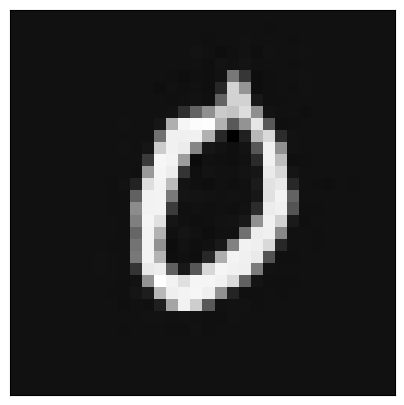

In [19]:
random_generation = False

if random_generation:
    latent_mat = torch.randn(1, 4, 8, 8).to(device)
else:
    inputs = batch_data["image"].to(device)
    input = inputs[0]
    input = input.unsqueeze(0)
    latent_mat = model.encode(images=input)

# Quantization of the latent sample
quantized_latent, _ = model.quantize(latent_mat)

# Decode the quantization sample
synthetic_image = model.decode(quantized_latent)
img = synthetic_image.squeeze().detach().cpu().numpy()
img = np.squeeze(img)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, xticks=[], yticks=[])
ax.imshow(img, cmap='gray')


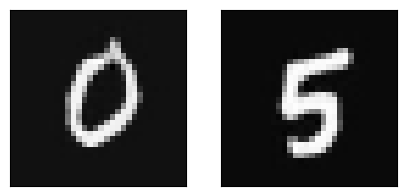

In [20]:
# Randomly select two points in the latent space
inputs = batch_data["image"].to(device)
input = inputs[0]
input = input.unsqueeze(0)
latent_1 = model.encode(images=input)
input = inputs[1]
input = input.unsqueeze(0)
latent_2 = model.encode(images=input)

# Quantization of the two latent samples
quant_1, _ = model.quantize(latent_1)
quant_2, _ = model.quantize(latent_2)
synthetic_1 = model.decode(quant_1)
synthetic_2 = model.decode(quant_2)

img_1 = synthetic_1.squeeze().detach().cpu().numpy()
img_1 = np.squeeze(img_1)
img_2 = synthetic_2.squeeze().detach().cpu().numpy()
img_2 = np.squeeze(img_2)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,2,1, xticks=[], yticks=[])
ax.imshow(img_1, cmap='gray')
ax = fig.add_subplot(1,2,2, xticks=[], yticks=[])
ax.imshow(img_2, cmap='gray')


In [21]:
def interpolate_images(model, latent_1, latent_2, steps=10):
    # Interpolate between point1 and point2 in the latent space

    latent_1.to(device)
    latent_2.to(device)
    t_values = torch.linspace(0, 1, steps).to(device)
    latent_tmp = [torch.lerp(latent_1, latent_2, t).to(device) for t in t_values]
    latent_interp = torch.stack([latent.squeeze(0) for latent in latent_tmp], dim=0)
    quantizers_interp, _ = model.quantize(latent_interp)
    synthetic_interp = model.decode(quantizers_interp)

    # Return images as a list after detaching and converting to numpy
    return [img.squeeze().detach().cpu().numpy() for img in synthetic_interp]

def save_animation_as_gif(images, filename="animation.gif", interval=200):
    fig, ax = plt.subplots(figsize = (4,4))
    img_display = ax.imshow(images[0], cmap="gray", vmin=0, vmax=1)
    ax.axis("off")

    def update(frame):
        img_display.set_data(images[frame])
        return [img_display]

    ani = FuncAnimation(fig, update, frames=len(images), interval=interval, blit=True)
    ani.save(filename, writer="pillow", fps=1000//interval)
    plt.close(fig)


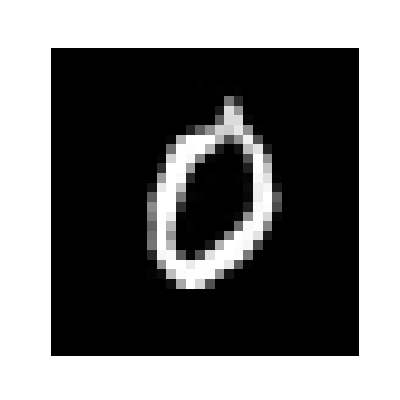

In [22]:
# Interpolate between the two points and decode to generate images
images = interpolate_images(model, latent_1, latent_2, steps=64)

# Animate the interpolated images
filename = "mnist_interpolation.gif"
save_animation_as_gif(images, filename=filename, interval=100)

# Affiche le GIF dans Jupyter
display(Image(filename=filename))